<a href="https://colab.research.google.com/github/sohitjii/Comparative-study-between-Vgg16-and-AlexNet/blob/main/potato_disease_classification_using_RSNet_model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Potato Disease Classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import all the Dependencies

In [2]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Set all the Constants

In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 227
CHANNELS=3
EPOCHS=50

In [5]:


IMAGE_SIZE = 227
BATCH_SIZE = 32
shuffle=True
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/modling workshop/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 227, 227, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]



As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

### Visualization of dataset

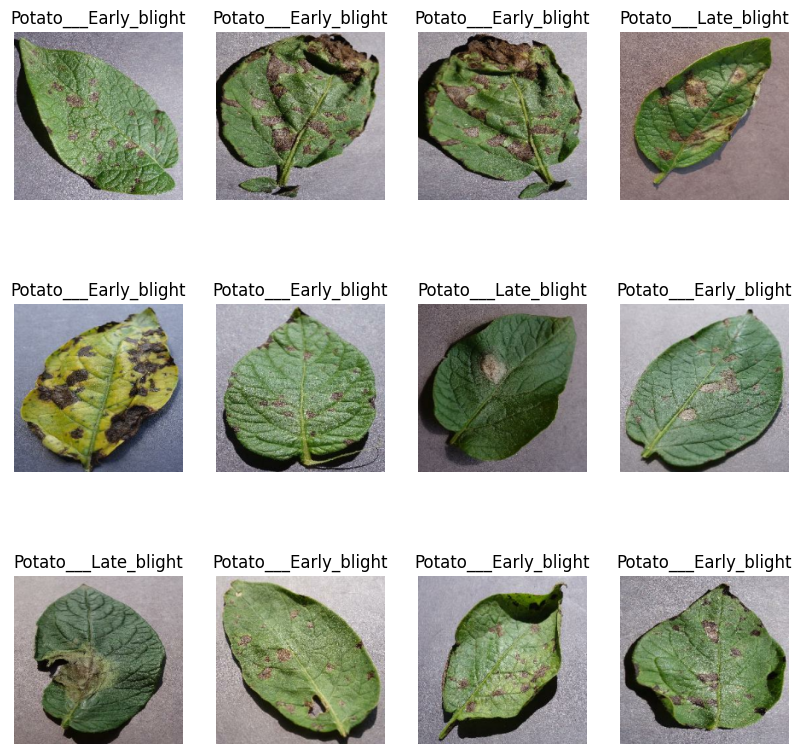

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,  
                         
                          
                          4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [9]:
len(dataset)

68

In [10]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [13]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

54

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)

8

### Cache, Shuffle, and Prefetch the Dataset
prefetch transformation. It can be used to decouple the time when data is produced from the time when data is consumed

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [24]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [101]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

# Define the model
inputs = keras.Input(shape=input_shape)
x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

x = rs_block(x, n_filters=64, strides=(1, 1))
x = rs_block(x, n_filters=64, strides=(1, 1))
x = rs_block(x, n_filters=64, strides=(1, 1))

x = rs_block(x, n_filters=128, strides=(2, 2))
x = rs_block(x, n_filters=128, strides=(1, 1))
x = rs_block(x, n_filters=128, strides=(1, 1))
x = rs_block(x, n_filters=128, strides=(1, 1))

x = rs_block(x, n_filters=256, strides=(2, 2))
x = rs_block(x, n_filters=256, strides=(1, 1))
x = rs_block(x, n_filters=256, strides=(1, 1))
x = rs_block(x, n_filters=256, strides=(1, 1))
x = rs_block(x, n_filters=256, strides=(1, 1))
x = rs_block(x, n_filters=256, strides=(1, 1))

x = rs_block(x, n_filters=512, strides=(2, 2))
x = rs_block(x, n_filters=512, strides=(1, 1))
x = rs_block(x, n_filters=512, strides=(1, 1))

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(n_classes, activation='softmax')(x)

model = keras.Model(inputs, outputs)


In [102]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 114, 114, 64  9472        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_13 (BatchN  (None, 114, 114, 64  256        ['conv2d_13[0][0]']              
 ormalization)                  )                                                             

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [103]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [104]:
import time

In [105]:
%%time
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,

    
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 81s 572ms/step - loss: 0.4120 - accuracy: 0.8675 - val_loss: 25685.3457 - val_accuracy: 0.4896
Epoch 2/50
54/54 [==============================] - 29s 538ms/step - loss: 0.2036 - accuracy: 0.9259 - val_loss: 155.0718 - val_accuracy: 0.5625
Epoch 3/50
54/54 [==============================] - 29s 538ms/step - loss: 0.2794 - accuracy: 0.8976 - val_loss: 18.0424 - val_accuracy: 0.4896
Epoch 4/50
54/54 [==============================] - 29s 538ms/step - loss: 0.2718 - accuracy: 0.9080 - val_loss: 7.4720 - val_accuracy: 0.5521
Epoch 5/50
54/54 [==============================] - 30s 551ms/step - loss: 0.1940 - accuracy: 0.9242 - val_loss: 45.5058 - val_accuracy: 0.0729
Epoch 6/50
54/54 [==============================] - 29s 541ms/step - loss: 0.1724 - accuracy: 0.9352 - val_loss: 13.4324 - val_accuracy: 0.2396
Epoch 7/50
54/54 [==============================] - 29s 538ms/step - loss: 0.1584 - accuracy: 0.9450 - val_loss: 8.1957 - val_accurac

In [106]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 152ms/step - loss: 0.3399 - accuracy: 0.9453


**You can see above that we get 96.48% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [107]:
scores


[0.3398856222629547, 0.9453125]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [108]:
history

In [109]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [110]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [111]:
type(history.history['loss'])

list

In [112]:
len(history.history['loss'])

50

In [113]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.4119586944580078,
 0.20363061130046844,
 0.27943047881126404,
 0.27175480127334595,
 0.19395485520362854]

In [114]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

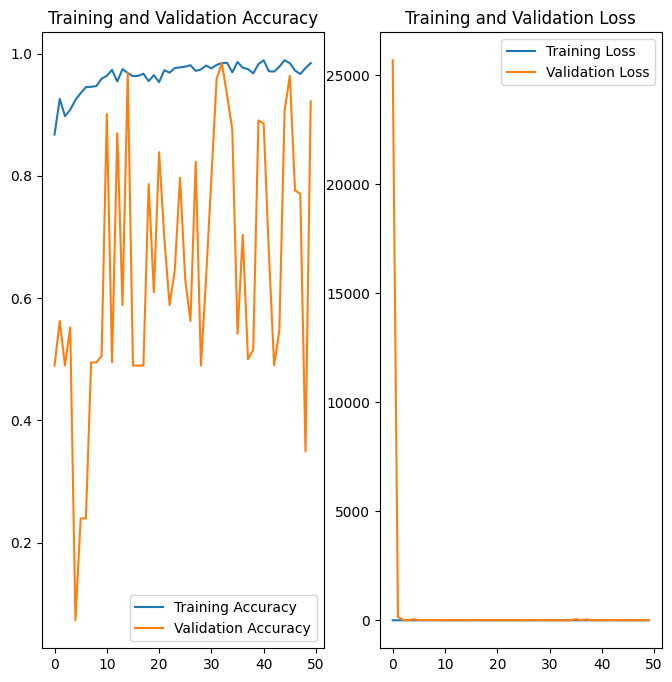

In [115]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 1s/step
predicted label: Potato___Late_blight


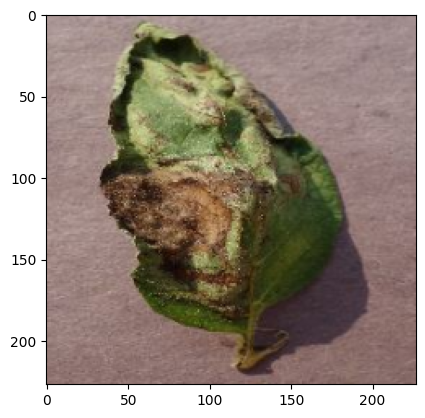

In [116]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [117]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 25ms/step


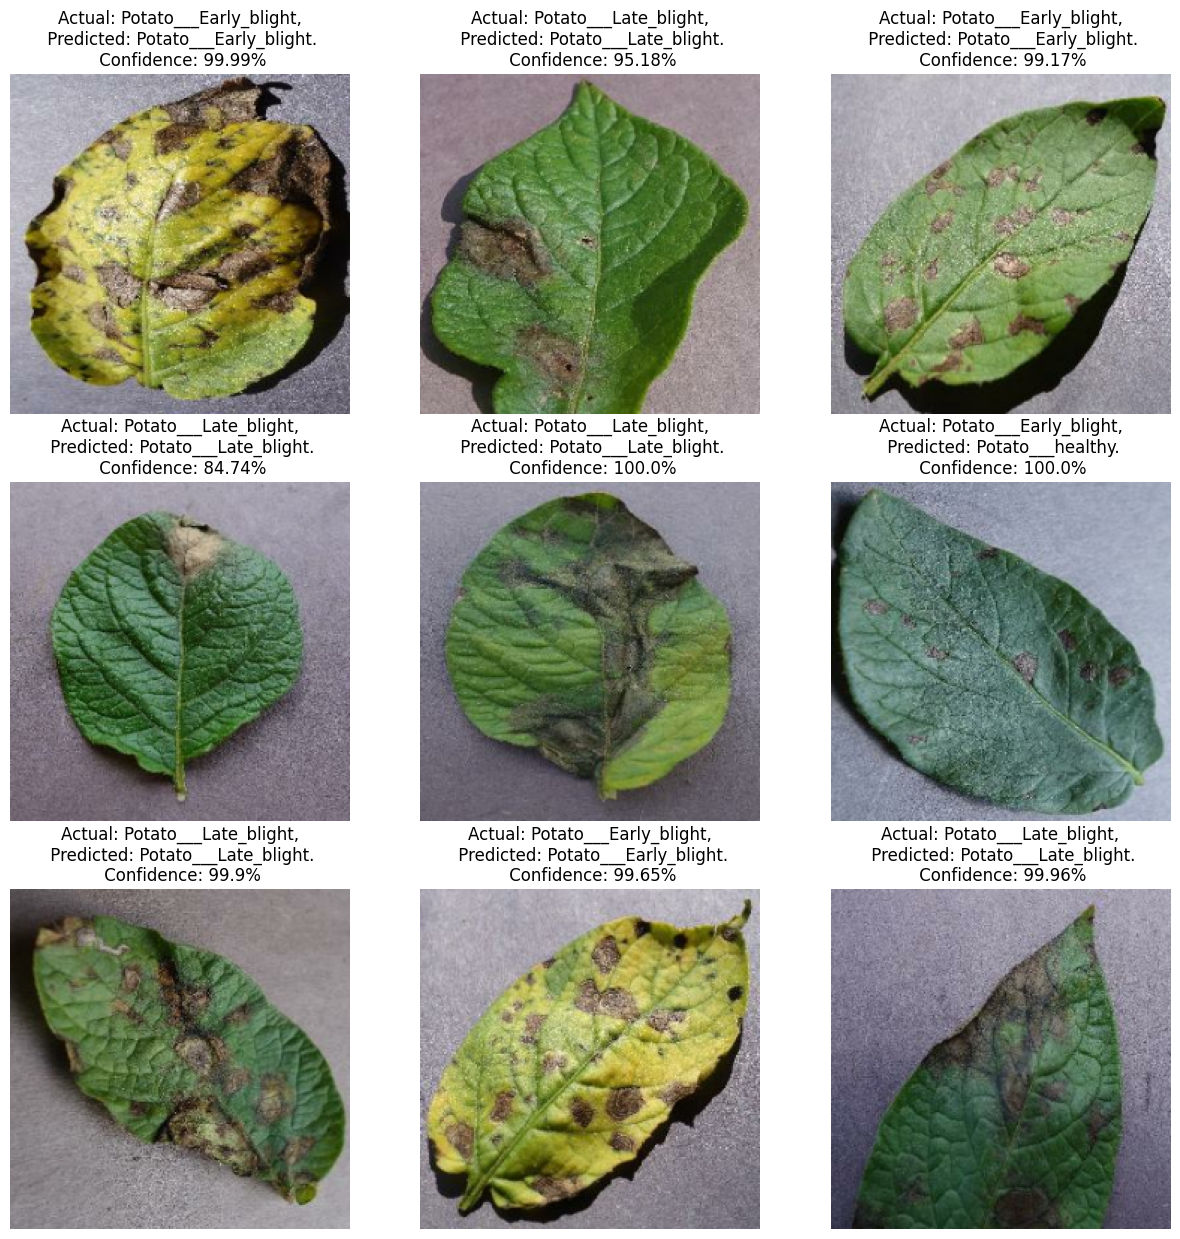

In [118]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")